<a href="https://colab.research.google.com/github/felipe-parodi/Imitation4HumanGait/blob/main/examples/openmonkey/LiftPose3D_monkeydemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODOS


1.  Unzip only subset of OMP data
2.  Comment all code 
3.  Lift your own data? 
4. Calculate joint angles



# LiftPose3D: a deep learning-based approach for transforming two-dimensional to three-dimensional poses in laboratory animals

**Abstract**: Markerless three-dimensional (3D) pose estimation has become an indispensable tool for kinematic studies of laboratory animals. Most current methods recover 3D poses by multi-view triangulation of deep network-based two-dimensional (2D) pose estimates. However, triangulation requires multiple synchronized cameras and elaborate calibration protocols that hinder its widespread adoption in laboratory studies. Here we describe LiftPose3D, a deep network-based method that overcomes these barriers by reconstructing 3D poses from a single 2D camera view. We illustrate LiftPose3D’s versatility by applying it to multiple experimental systems using flies, mice, rats and macaques, and in circumstances where 3D triangulation is impractical or impossible. Our framework achieves accurate lifting for stereotypical and nonstereotypical behaviors from different camera angles. Thus, LiftPose3D permits high-quality 3D pose estimation in the absence of complex camera arrays and tedious calibration procedures and despite occluded body parts in freely behaving animals.


## This notebook will show you how to:

*   Train and visualize LiftPose3D on the OpenMonkeyPose dataset.
*   Calculate joint angles with your lifted predictions.

Before starting, set compute node to GPU: Runtime --> Change runtime type --> GPU --> Save.

# **Setup**



### Prep Drive and Install LiftPose3D
Run this sequence to install LiftPose3D on this node.

In [3]:
#@markdown Mount google drive
from google.colab import drive
drive.mount('/content/drive')

!ls # Check contents of drive
%cd drive/MyDrive

# Time cell execution
!pip install ipython-autotime &> /dev/null
%load_ext autotime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'   OpenMonkeyStudio   Personal   UMiami   UPenn
[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive
time: 209 µs (started: 2021-12-27 18:42:38 +00:00)


In [4]:
# Create and move into project folder titled "OpenMonkeyStudio"
import os

path = "/content/drive/MyDrive/OpenMonkeyStudio/"

try:
    os.mkdir(path)
except:
    print("Folder already found!")

%cd /content/drive/MyDrive/OpenMonkeyStudio/

Folder already found!
/content/drive/MyDrive/OpenMonkeyStudio
time: 8.75 ms (started: 2021-12-27 18:42:52 +00:00)


In [3]:
# Clone LiftPose3D repo in project folder
!git clone https://github.com/NeLy-EPFL/LiftPose3D.git

Cloning into 'LiftPose3D'...
remote: Enumerating objects: 6526, done.
remote: Counting objects: 100% (918/918), done.
remote: Compressing objects: 100% (467/467), done.
remote: Total 6526 (delta 538), reused 762 (delta 438), pack-reused 5608
Receiving objects: 100% (6526/6526), 899.50 MiB | 11.85 MiB/s, done.
Resolving deltas: 100% (2345/2345), done.
Checking out files: 100% (126/126), done.


### Download OpenMonkeyPose dataset

Here we will download the dataset directly to our google drive.

In [39]:
# Download and unzip OpenMonkeyStudio dataset at https://z.umn.edu/OMS_data_link
# Link is modified to directly download to pwd
!gdown https://drive.google.com/u/0/uc?id=1WJl1ttaTsCUVDdVs1FhV8OZSiadmAlgW&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1WJl1ttaTsCUVDdVs1FhV8OZSiadmAlgW
To: /content/drive/My Drive/OpenMonkeyStudio/OMS_Dataset.zip
100% 3.84G/3.84G [01:00<00:00, 63.4MB/s]


In [ ]:
# Unzip dataset
# except downloading the entire dataset takes too much time and space
!unzip OMS_Dataset.zip &> /dev/null

# Here, we will only unzip 2 batches, corresponding images, and metadata:
# batch 7
# batch 9
# Images/batch7_
# Images/batch9_

### Import Packages

In [5]:
#@markdown Import packages
%load_ext autoreload
%matplotlib inline

import numpy as np
import sys
import torch
import yaml
import random
import logging
from tqdm import tqdm
from imp import reload
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcol
from matplotlib.ticker import NullFormatter

reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
tqdm.get_lock().locks = []

!pip install liftpose

import liftpose
from liftpose.main import train as lp3d_train
from liftpose.main import test as lp3d_test
from liftpose.vision_3d import world_to_camera
from liftpose.postprocess import load_test_results
from liftpose.plot import read_log_train, plot_log_train
from liftpose.plot import violin_plot
from liftpose.plot import plot_pose_3d

%cd /content/drive/MyDrive/OpenMonkeyStudio/LiftPose3D/examples/openmonkey
from load import *
from plot_util import *

     |████████████████████████████████| 48 kB 2.2 MB/s 
/content/drive/MyDrive/OpenMonkeyStudio/LiftPose3D/examples/openmonkey
time: 11.5 s (started: 2021-12-27 18:43:25 +00:00)


# **Part I: Train LiftPose3D**

## Load data

In [7]:
# Move into dataset folder within project folder
%cd '/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset'

# Declare training and test parameters
# Training on multiple batches will take long, so we only train on batch 7
par_train = {'data_dir'       : '/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset', #mac/ubuntu path
             'out_dir'        : '/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out', 
            #  'train_subjects' : ["7", "9a", "9b", "10", "11"],
             'train_subjects' : ["7"],
             'test_subjects'  : ["9"]}

# Access parameter file
path2yaml = '/content/drive/MyDrive/OpenMonkeyStudio/LiftPose3D/examples/openmonkey/param.yaml'

# Merge with training parameters
with open(path2yaml) as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    par_data = yaml.full_load(file)
    par = {**par_data['data'], **par_train}

/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset
time: 723 ms (started: 2021-12-27 18:45:00 +00:00)


In [8]:
# Load data
train_2d, train_3d, train_keys = list(), list(), list()
for btch in par_train["train_subjects"]:
    Data, _ = get_btch(btch, par_train["data_dir"])
    for idx, (k,v) in enumerate(Data.items()):
        train_2d.append(Data[k]["points2d"])
        train_3d.append(Data[k]["points3d"])
        train_keys.append(k)

test_2d, test_3d, test_keys = list(), list(), list()
for btch in par_train["test_subjects"]:
    Data, _ = get_btch(btch, par_train["data_dir"])
    for idx, (k,v) in enumerate(Data.items()):
        test_2d.append(Data[k]["points2d"])
        test_3d.append(Data[k]["points3d"])
        test_keys.append(k)

train_2d, train_3d = np.stack(train_2d), np.stack(train_3d)
test_2d, test_3d = np.stack(test_2d), np.stack(test_3d)

# Remove data with large variance for smoother training
good_ind = np.where((train_2d.reshape(train_2d.shape[0], -1)).std(axis=1) < 1000)[0]
train_2d = train_2d[good_ind]
train_3d = train_3d[good_ind]

# L2 Normalization
train_2d /= np.linalg.norm(train_2d, axis=(-1,-2), keepdims=True)
test_2d /= np.linalg.norm(test_2d, axis=(-1,-2), keepdims=True)

/content/drive/MyDrive/OpenMonkeyStudio/LiftPose3D/examples/openmonkey/load.py:110: RuntimeWarning: invalid value encountered in true_divide
  offset = (vec / curr_length) * (bone_length[idx] - curr_length)


time: 1min 55s (started: 2021-12-27 18:45:07 +00:00)


## Train Model

In [30]:
# Training LiftPose3D model; adjust hyperparams as needed
lp3d_train(train_2d={'train': train_2d}, test_2d={'test': test_2d}, 
           train_3d={'train': train_3d}, test_3d={'test': test_3d},
           roots=par['roots'], target_sets=par['target_sets'], out_dir=par['out_dir'],
           training_kwargs={"epochs":30, "lr_decay":10000, "dropout":0.2})

[main.py:146]:INFO:Creating directory /content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out
[main.py:191]:INFO:Saving pre-processed 2D data at /content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out/stat_2d.pth.tar.
[main.py:210]:INFO:Saving pre-processed 3D data at /content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out/stat_3d.pth.tar.
[main.py:237]:INFO:Starting training model.
[main.py:248]:DEBUG:
==================Options=================
[main.py:249]:DEBUG:{   'batch_size': 64,
    'data_dir': '/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out',
    'drop_input': 0.0,
    'dropout': 0.2,
    'epochs': 30,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 10000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out',
    'out_dir': '/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out',
    'predict

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  0.67264|: 100%|██████████| 490/490 [00:10<00:00, 48.55it/s]
  0%|          | 0/490 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

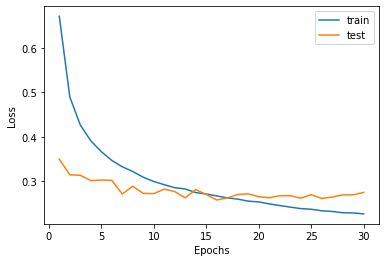

In [31]:
# Plot learning curves
epoch, lr, loss_train, loss_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)
#plt.savefig('loss.svg')

In [32]:
# Save outputs as tar files
lp3d_test(par['out_dir'])

stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, _ = load_test_results(par['out_dir'], stat_2d, stat_3d)

[main.py:335]:INFO:starting testing in path: /content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out
[lift.py:44]:INFO:Training on the device: cuda:0
[lift.py:73]:INFO:total params: 4.27M
[lift.py:79]:INFO:loading ckpt from '/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out/ckpt_best.pth.tar'
[lift.py:87]:INFO:ckpt loaded (epoch: 16 | err: 0.25692200691033995)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[lift.py:120]:INFO:Saving results: /content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out/test_results.pth.tar


## Violin Plots

[utils.py:157]:INFO:NumExpr defaulting to 2 threads.


(0.0, 0.15)

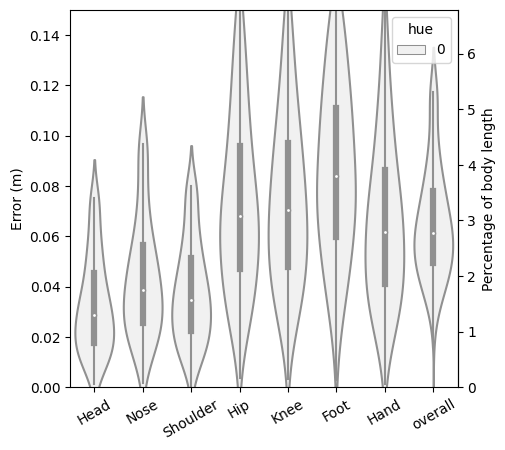

In [33]:
# Plot error plots for each body part
plt.figure(figsize=(5,5), dpi=100)

# Concat left and right limbs
names = par_data["vis"]["names"]
r = ['Head', 'Nose', 'RShoulder', 'Hip',  'RKnee', 'RFoot', 'RHand']
l = ['Head', 'Nose', 'Shoulder',  'Hip',  'Knee', 'Foot', 'Hand']
r_indices = [names.index(r_) for r_ in r]
l_indices = [names.index(l_) for l_ in l]
test_3d_gt_ord = np.concatenate([test_3d_gt[:,r_indices], test_3d_gt[:, l_indices]])
test_3d_pred_ord = np.concatenate([test_3d_pred[:,r_indices], test_3d_pred[:, l_indices]])

violin_plot(plt.gca(), gt=test_3d_gt_ord, pred=test_3d_pred_ord, good_keypts=np.ones_like(test_3d_pred_ord), 
            name=l, units='m', body_length=2.21)
plt.ylim([0,0.15])

## Plot individual lifted pose 

In [34]:
# Pick data to plot
Data, cameras = get_btch('9', par_train['data_dir'])

2607 ('9', 12240, '18260989')


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


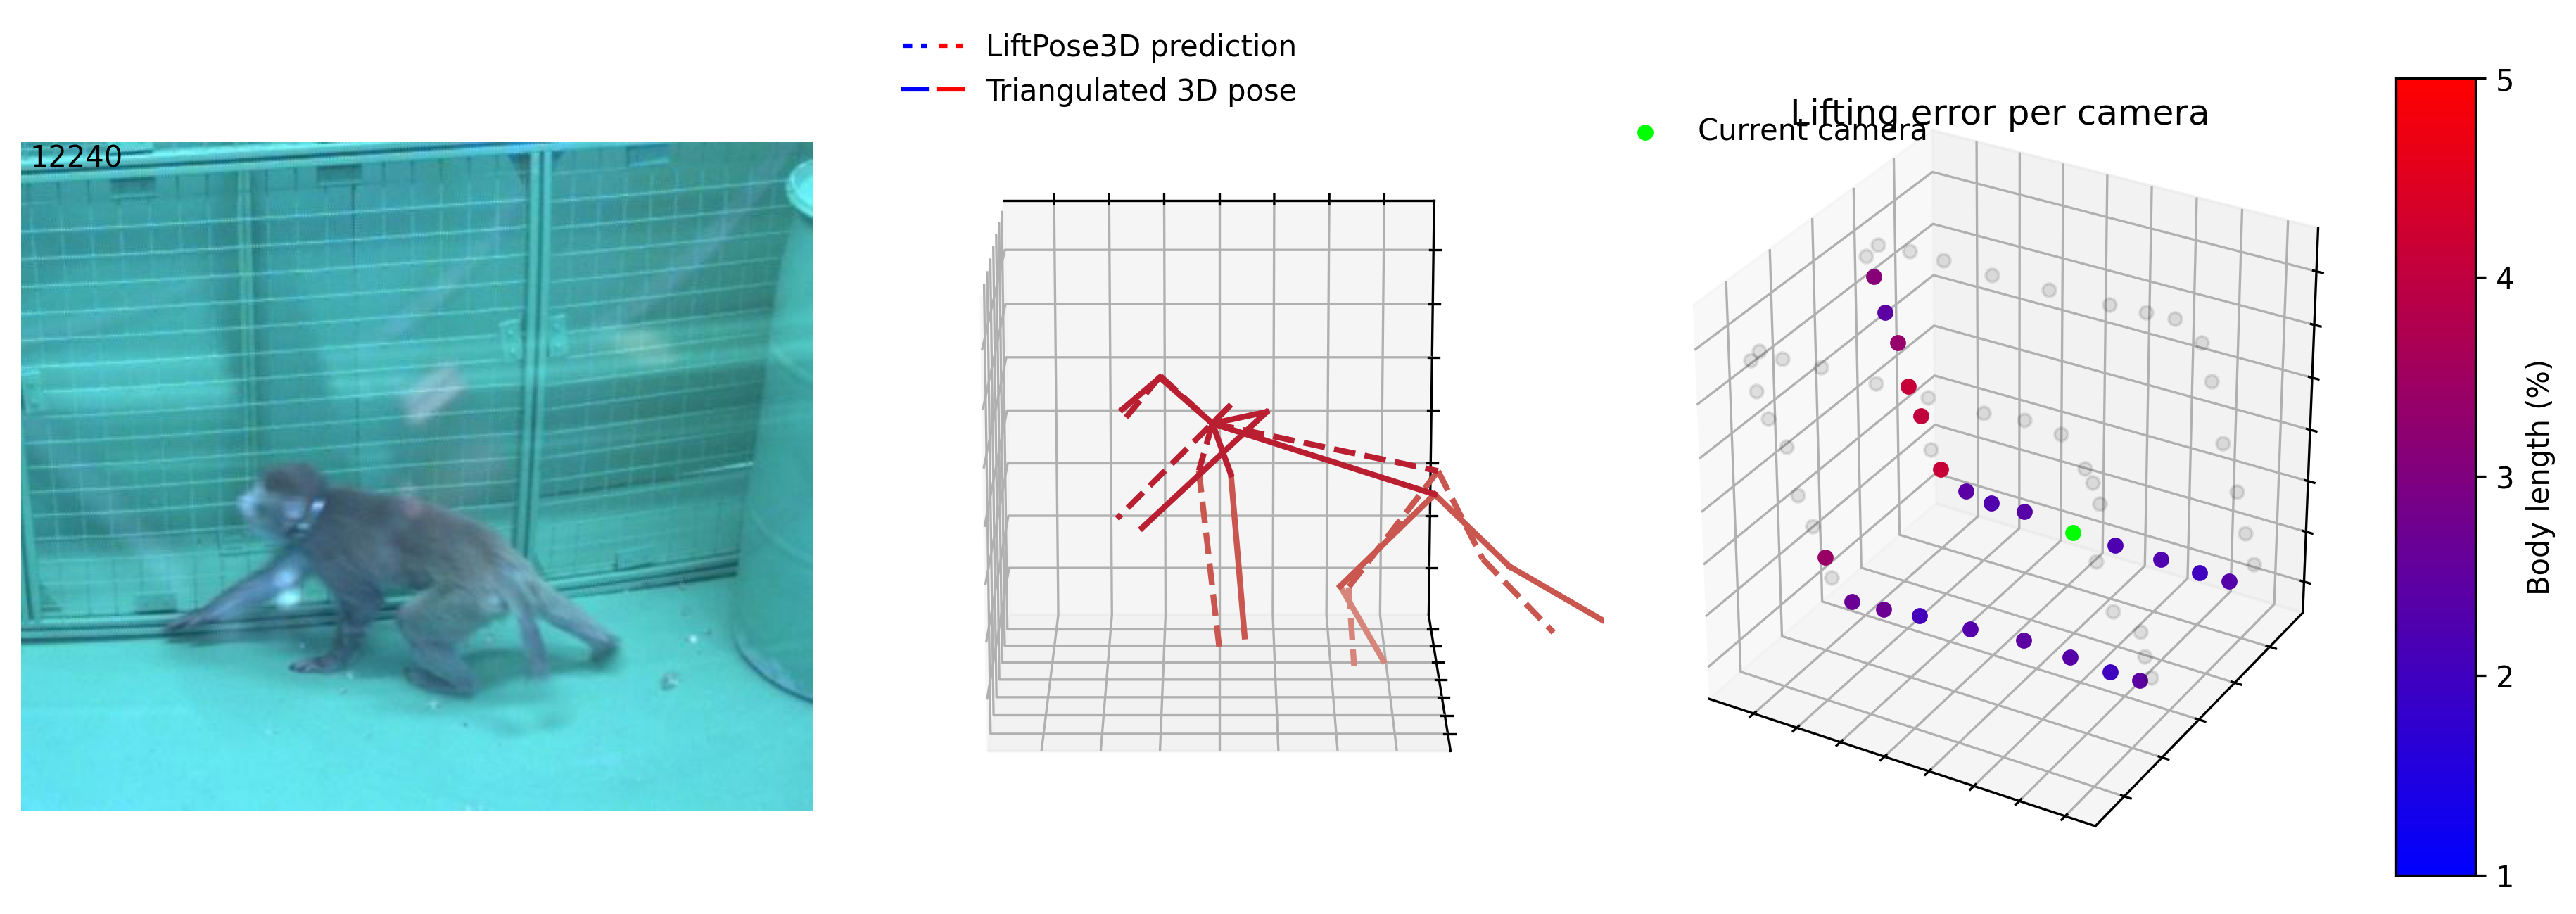

In [37]:
# Do the actual plotting
mpl.pyplot.rcParams["font.family"] = ['Arial']
mpl.rcParams.update({'font.size': 10})

# Define axis
fig = plt.figure(figsize=(15,5),dpi=300)
plt.subplots_adjust(wspace=0, hspace=0)
gs1 = fig.add_gridspec(nrows=1, ncols=31)
ax2d = fig.add_subplot(gs1[:, :10])
ax3d = fig.add_subplot(gs1[:, 10:20], projection='3d')
ax3d_cameras = fig.add_subplot(gs1[:, 20:30], projection='3d')
ax_bar = fig.add_subplot(gs1[:, -1])

# Load image and plot
idx = np.random.randint(test_3d_pred.shape[0])
k = list(Data.keys())[idx]
print(idx, k)

btch, img_id, cam = k
img_name = os.path.join(par['data_dir'], 'Images', 'batch' + str(btch) + '_' + str(img_id).zfill(9) + '_' + str(cam) + '.jpg')
ax2d.imshow(plt.imread(img_name))
ax2d.text(x=5, y=15, s=f"{img_id}")

ax3d.view_init(elev=-75, azim=-90)
plot_pose_3d(ax=ax3d, 
             bones=par_data["vis"]["bones"], 
             pred=test_3d_pred[idx],
             tar=test_3d_gt[idx],
             limb_id=par_data["vis"]["limb_id"], 
             colors=par_data["vis"]["colors"], 
             normalize=True,
             legend=True)

mi, ma = 1 / 100 * 2.2, 5 / 100 * 2.2
err = err_for_frame(Data, cameras, img_id, test_3d_gt, test_3d_pred)
plot_cameras_err(ax=ax3d_cameras, err=err, mi=mi, ma=ma, cameras=cameras, curr_camera=cam)

ax2d.axis('off')
lim = [-0.75, 0.75]
ax3d.set_xlim(lim)
ax3d.set_ylim(lim)
ax3d.set_zlim(lim)

# remove ticks
ax3d.xaxis.set_major_formatter(NullFormatter())
ax3d.yaxis.set_major_formatter(NullFormatter())
ax3d.zaxis.set_major_formatter(NullFormatter())
ax3d_cameras.xaxis.set_major_formatter(NullFormatter())
ax3d_cameras.yaxis.set_major_formatter(NullFormatter())
ax3d_cameras.zaxis.set_major_formatter(NullFormatter())

# setting titles
ax3d_cameras.set_title('Lifting error per camera')
cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
norm = mpl.colors.Normalize(vmin=mi/2.2 * 100, vmax=ma/2.2 * 100)
cb1 = mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap,
                                norm=norm,
                                orientation='vertical', ticks=[1,2,3,4,5])

p1 = ax3d_cameras.scatter(0,0,0, c=(0,1,0))
ax3d_cameras.legend([(p1)],
        ["Current camera"],
        numpoints=1,
        loc=(0.0, 0.9),
        frameon=False,
        )
p1.remove()
        
cb1.set_label('Body length (%)')

# **Part II: Video of Lifted Poses**

### Load data

In [47]:
# Load data
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
tqdm.get_lock().locks = []

# Declare training parameters
par_train = {'data_dir'       : '/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset', #mac/ubuntu path
             'out_dir'        : '/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out', 
            #  'train_subjects' : ["7", "9a", "9b", "10", "11"],
             'train_subjects' : ["7"],
             'test_subjects'  : ["11"]}

# Access parameter file
path2yaml = '/content/drive/MyDrive/OpenMonkeyStudio/LiftPose3D/examples/openmonkey/param.yaml'

# Merge with training parameters
with open(path2yaml) as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    par_data = yaml.load(file)
    par = {**par_data['data'], **par_train}
    print(par)

{'ndims': 38, 'in_dim': 2, 'out_dim': 3, 'dims_to_exclude': [15, 16, 17, 18, 34, 35, 36, 37], 'roots': [2], 'target_sets': [[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]], 'data_dir': '/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset', 'out_dir': '/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out', 'train_subjects': ['7'], 'test_subjects': ['11']}


## Run inference

In [48]:
# Run inference and save data
lp3d_test(par['out_dir'])

stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, _ = load_test_results(par['out_dir'], stat_2d, stat_3d)
Data, cameras = get_btch('11', par_train["data_dir"])

[main.py:335]:INFO:starting testing in path: /content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out
[lift.py:44]:INFO:Training on the device: cuda:0
[lift.py:73]:INFO:total params: 4.27M
[lift.py:79]:INFO:loading ckpt from '/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out/ckpt_best.pth.tar'
[lift.py:87]:INFO:ckpt loaded (epoch: 16 | err: 0.25692200691033995)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[lift.py:120]:INFO:Saving results: /content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/out/test_results.pth.tar


KeyboardInterrupt: ignored

## Plot several images with lifted pose

FileNotFoundError: ignored

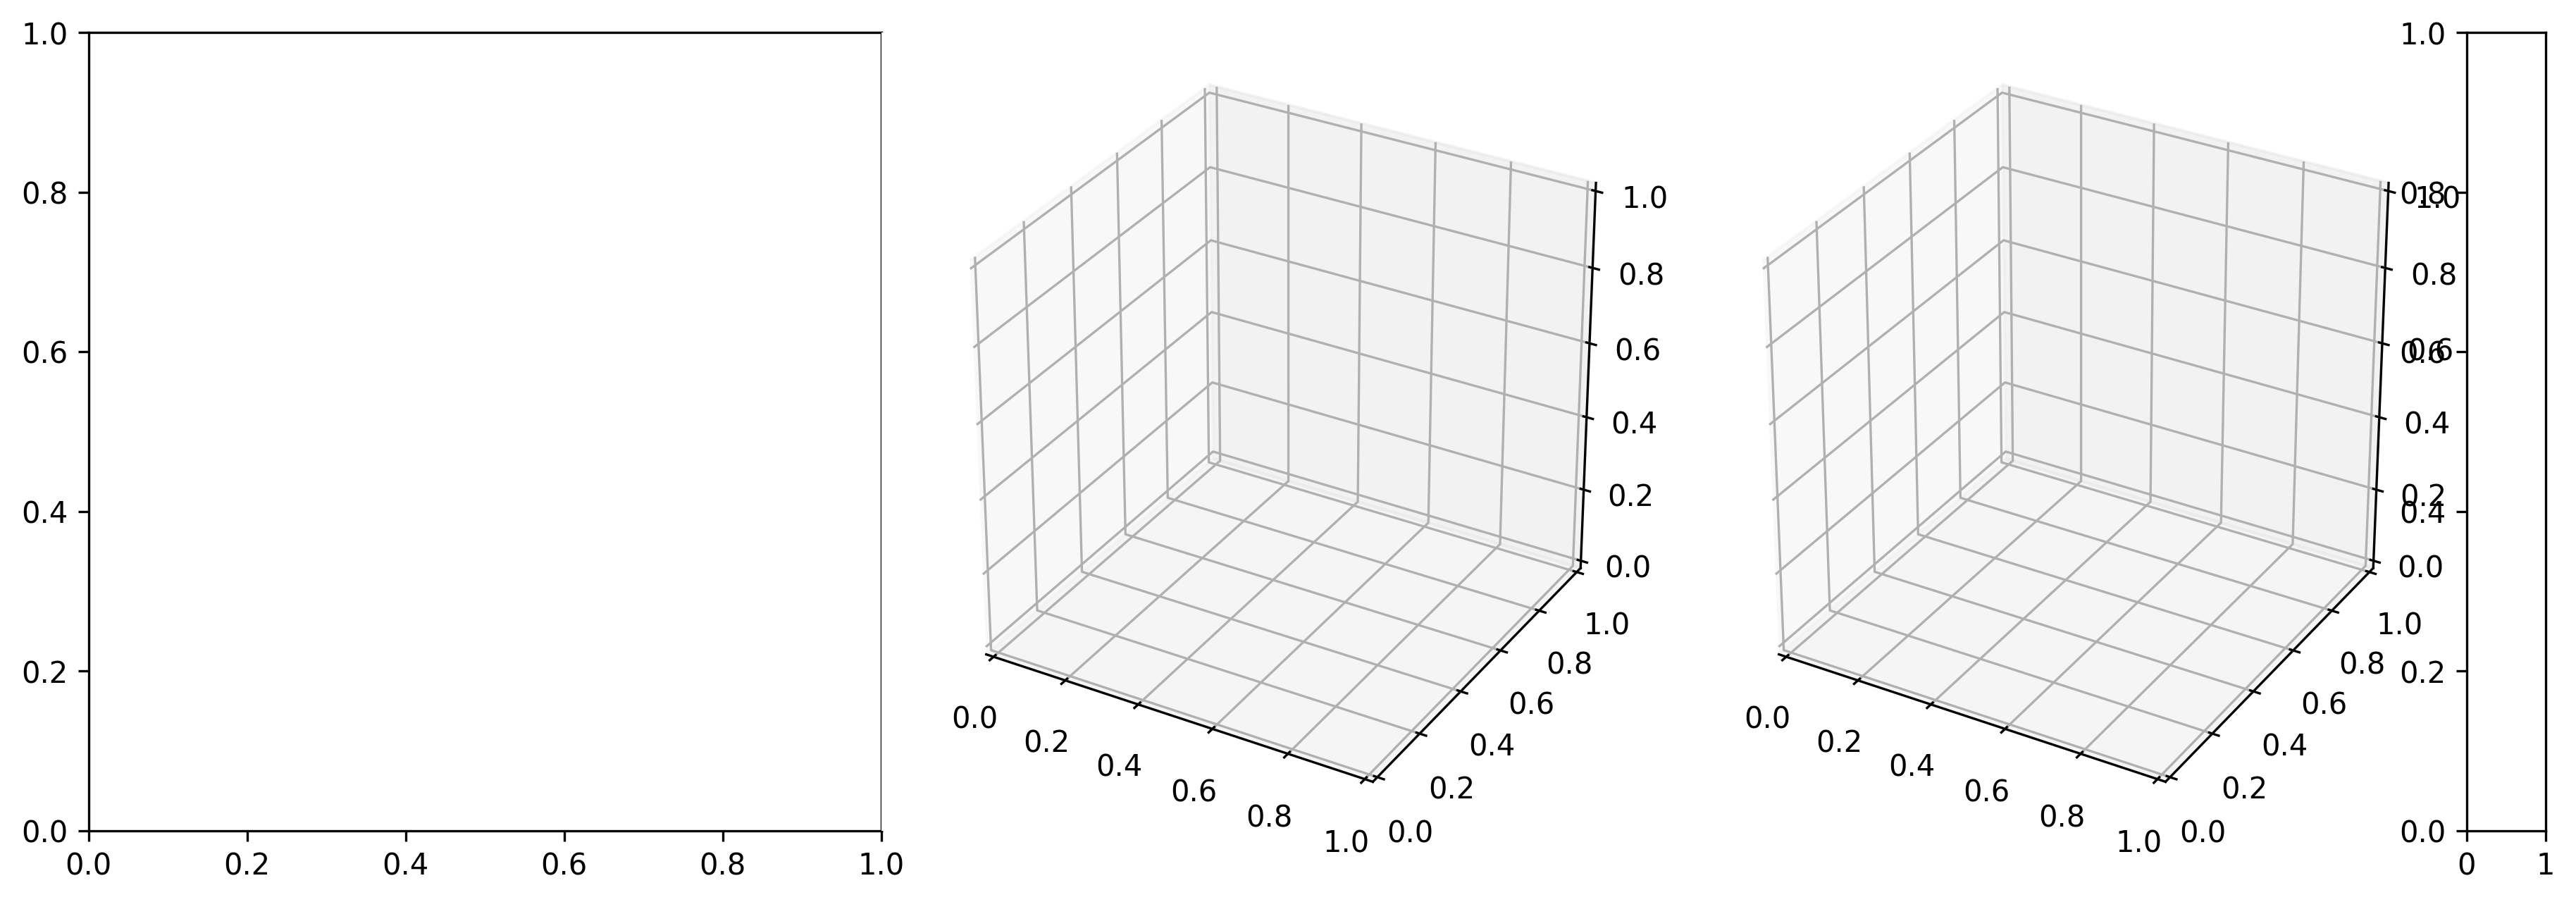

In [44]:
# Plot raw image, lifted pose, and camera error
mpl.pyplot.rcParams["font.family"] = ['Arial']
mpl.rcParams.update({'font.size': 10})
np.random.seed(0)

fig = plt.figure(figsize=(15,5), dpi=300)
plt.subplots_adjust(wspace=0, hspace=0)
gs1 = fig.add_gridspec(nrows=1, ncols=31)
ax2d = fig.add_subplot(gs1[:, :10])
ax3d = fig.add_subplot(gs1[:, 10:20], projection='3d')
ax3d_cameras = fig.add_subplot(gs1[:, 20:30], projection='3d')
ax_bar = fig.add_subplot(gs1[:, -1])



idx = random.sample(list(np.arange(test_3d_pred.shape[0])),1000)
for j, i in enumerate(idx):
    k = list(Data.keys())[i]

    btch, img_id, cam = k
    img_name = os.path.join(par['data_dir'], 'Images', 'batch' + str(btch) + '_' + str(img_id).zfill(9) + '_' + str(cam) + '.jpg')
    ax2d.imshow(plt.imread(img_name))
    ax2d.text(x=5, y=15, s=f"{img_id}")

    ax3d.view_init(elev=-75, azim=-90)
    plot_pose_3d(ax=ax3d,
                 bones=par_data["vis"]["bones"], 
                 pred=test_3d_pred[i],
                 tar=test_3d_gt[i],
                 limb_id=par_data["vis"]["limb_id"], 
                 colors=par_data["vis"]["colors"], 
                 normalize=True,
                 legend=True,
                 axes=False)

    mi, ma = 2 / 100 * 2.2, 10 / 100 * 2.2
    err = err_for_frame(Data, cameras, img_id, test_3d_gt, test_3d_pred)
    plot_cameras_err(ax=ax3d_cameras, err=err, mi=mi, ma=ma, cameras=cameras, curr_camera=cam)

    #set axes
    ax2d.axis('off')
    lim = [-0.75, 0.75]
    ax3d.set_xlim(lim)
    ax3d.set_ylim(lim)
    ax3d.set_zlim(lim)

    # setting titles
    ax3d_cameras.set_title('Lifting error per camera')
    cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
    norm = mpl.colors.Normalize(vmin=mi/2.2 * 100, vmax=ma/2.2 * 100)
    cb1 = mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical',  ticks=np.arange(2, 10))
    cb1.set_label('Body length (%)',fontsize=13)
    
    p1 = ax3d_cameras.scatter(0,0,0, color=(0,1,0))
    ax3d_cameras.legend([(p1)],
        ["Current camera"],
        numpoints=1,
        loc=(0.0, 0.9),
        frameon=False,
        )
    p1.remove()
    ax3d_cameras.set_xticklabels([])
    ax3d_cameras.set_yticklabels([])
    ax3d_cameras.set_zticklabels([])
    
    plt.savefig(os.path.join(par_train["out_dir"], 'img{:03d}.jpg'.format(j)))
    ax3d_cameras.clear()
    ax3d.clear()
    ax2d.clear()

/content/drive/MyDrive/OpenMonkeyStudio/OMS_Dataset/Images

In [ ]:
# add flag -vb 20M for high quality
!ffmpeg -framerate 2 -i /content/drive/MyDrive/OpenMonkeyStudio/LiftPose3D/out


# **Part III: Lift your own data**

In [ ]:
# ...

# **Part IV: Analyzing Lifted Data**

In [ ]:
# calculating joint angles or applying a filter (anipose)
# or clustering (bsoid)

# **Clean up drive**
Run this cell if you'd like to remove the created project folder from your Google Drive.

In [ ]:
!rm -r /content/drive/MyDrive/OpenMonkeyStudio